In [51]:
import pkgutil
import importlib
import logging
import traceback
from collections import defaultdict
import random
import copy
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as P
import matplotlib.pyplot as plt

from liveplots.xmlrpcserver import rpc_plot
import xmlrpc.client

matplotlib.use ('Agg')

%matplotlib inline

In [6]:
jogadores = [name for _,name,_ in pkgutil.iter_modules(['estrategias'])]

jogadores.remove('jogadores')
print(jogadores)

['Adriano1', 'Adriano2', 'Adriano3', 'Ale_atoria', 'AleaJactaEst', 'Alessandro1', 'Alessandro2', 'Alessandro3', 'AntonioPulcherio', 'AraraClayton', 'Arthur', 'Arthur2', 'Atilio_Dumbledore', 'Atilio_Gandalf', 'Atilio_Mestre_dos_Magos', 'BelloDenner', 'Cadu', 'Cascalho', 'Cascao', 'Cebolinha', 'Cecilia1', 'Cecilia2', 'ChicoBento', 'CorreVento', 'Damn', 'Daniel', 'DennerLindão', 'DrFome', 'Du', 'Dudu', 'Eliane', 'Eliane2', 'Fabio21', 'Fernanda', 'FlavioCCoelho', 'FlavioCoelho', 'Fuck', 'Gabriel', 'Gabrielp', 'GuapoDenner', 'GuilhermeBarros', 'GuilhermeCaçador', 'GuilhermePassos', 'GuilhermePassos2', 'GuilhermePassos3', 'GuilhermeRandom', 'GuilhermeRandomMorreu', 'HandsomeDenner', 'JoaoHonesto', 'Jonas', 'KatnissEverdin', 'Lauder_Loki', 'Lauder_Thanos', 'Lauder_Venom', 'LeoRodrigues', 'LeonardoPinheiro', 'LordVoldemort', 'Luciene', 'LuisEduardo', 'LunaLovegood', 'MaisOuMenos', 'MaxRep', 'MediaAna', 'Media_Ale', 'Medusa', 'MissLestrange', 'Moschen1', 'Moschen2', 'Moschen3', 'Oda', 'Otto', '

In [16]:
jogadores = [j for j in jogadores if j.lower().startswith('a')]
jogadores

['Adriano1',
 'Adriano2',
 'Adriano3',
 'Ale_atoria',
 'AleaJactaEst',
 'Alessandro1',
 'Alessandro2',
 'Alessandro3',
 'AntonioPulcherio',
 'AraraClayton',
 'Arthur',
 'Arthur2',
 'Atilio_Dumbledore',
 'Atilio_Gandalf',
 'Atilio_Mestre_dos_Magos']

In [26]:
class Torneio(object):
    def __init__(self):
        self.historico = defaultdict(lambda: {"comida": [], "reputacao": [], "cacou": 0, "descansou": 0})
        self.jogadores = None # dicionario com as instancias dos jogadores;
        self.recompensa = []
        self.cemiterio = {}
        self.rodada = 0
        self.bugados = {}
        self.M = [] #série de m
        self.comida_plot = xmlrpc.client.ServerProxy('http://localhost:{}'.format(rpc_plot(persist=1)))
        self.recompensa_plot = xmlrpc.client.ServerProxy('http://localhost:{}'.format(rpc_plot(persist=1)))



    @property
    def p(self):
        if self.jogadores is None:
            return 0
        return len(self.jogadores)

    def inicializa_jogadores(self, comida=300.0):
        self.jogadores = {x:importlib.import_module("estrategias.{}".format(x)).MeuJogador() for x in jogadores}
        for nome, jogador in self.jogadores.items():
            self.historico[nome]["comida"].append(comida*(self.p-1))
            self.historico[nome]["reputacao"].append(0.)
        self.inicializa_saida()

    def inicializa_saida(self):
        mode = "w"
        cabecalho = ','.join(self.historico.keys()) + '\n'
        with open("comida.csv", mode) as f:
            f.write(cabecalho)
        with open("reputacao.csv", mode) as f:
            f.write(cabecalho)
        with open("recompensa.csv", mode) as f:
            f.write("recompensa")

    def roda_rodada(self):
        """
        Coleta as escolhas de cada jogador
        """
        self.rodada += 1
        if self.rodada%20 == 0:
            print("Iniciando Rodada {}".format(self.rodada))
        jogadores_randomizados = [jog for jog in self.jogadores.keys() if jog not in self.bugados]
        random.shuffle(jogadores_randomizados)
        m = random.randrange(0, self.p*(self.p-1))
        self.M.append(m)
        escolhas = {}
        
        for nome in jogadores_randomizados:
            jogador = self.jogadores[nome]
            adversarios = copy.copy(jogadores_randomizados)
            adversarios.remove(nome)
            reputacoes = tuple([self.historico[nome_adv]["reputacao"][-1] for nome_adv in adversarios])
            try:
                escolhas[nome] = (jogador.escolha_de_cacada(self.rodada, self.historico[nome]["comida"][-1],
                                                            self.historico[nome]["reputacao"][-1],
                                                            m, 
                                                            reputacoes), 
                                  tuple(adversarios))
            except Exception as e:
                #logging.error(traceback.format_exc())
                #print(e.__doc__)
                #print(e.message)
                escolhas[nome] = (['c' for i in reputacoes], adversarios)
                self.bugados[nome] = (self.rodada, e)
                self.cemiterio[nome] = self.rodada
                
            self.historico[nome]["cacou"] += sum([e == 'c' for e in escolhas[nome][0]])
            self.historico[nome]["descansou"] += sum([e == 'd' for e in escolhas[nome][0]])
        saldo = self.calcula_resultado_cacadas(escolhas)
        recompensa, cacadas = self.calcula_recompensa(escolhas)
        
        R.write(str(recompensa) + "\n")
        for nome, jogador in self.jogadores.items():
            jogador.resultado_da_cacada(saldo)
            jogador.fim_da_rodada(recompensa, self.M[-1], cacadas)
        self.atualiza_reputacao()
        self.atualiza_comida(saldo, recompensa)
        
        #==== Monitor the situation
        self.monitor()
        #=============
        
        for nome in self.bugados.keys():
            if nome in self.cemiterio:
                continue
            # self.enterra(nome)
            print("{} Morreu bugado, na rodada {}. Erro: {}".format(nome, self.rodada, self.bugados[nome]))

    def monitor(self, fim=False):
        """
        Plot simulation status using liveplots
        :return:
        """
        window_size = 2000
        if self.rodada % 1000 == 0 or fim:
            com_series = [self.historico[nome]["comida"][-window_size:] for nome in jogadores] #if nome not in self.cemiterio]
            jogs = [j for j in jogadores ]#if j not in self.cemiterio]
            xmin = self.rodada-window_size if self.rodada >= window_size else 0
            xmax = self.rodada+window_size if self.rodada >= window_size else self.rodada
            xs = list(range(xmin, xmax))
            self.comida_plot.lines(com_series, xs, jogs, "Comida por Jogador", 'lines', 0)
            self.recompensa_plot.lines([self.recompensa[-window_size:]], xs, ['recompensa'], "recompensa", 'lines', 0)

    def calcula_resultado_cacadas(self, escolhas):
        """
        Calcula comida obtida em todas as caçadas e retorna o saldo por jogador

        :rtype : defaultdict
        :param escolhas:
        :return:
        """
        saldo = defaultdict(lambda: [])  # saldo de todos as cacadas por jogador
        cooperadores = []
        for nome_jogador, cacadas in escolhas.items():
            for decisao, adversario in zip(*cacadas):
                gasto = -2 if decisao == 'd' else -6
                ganho_pessoal = 6 if decisao == 'c' else 0
                #print len(escolhas[adversario][0]), tuple(escolhas[adversario][1]).index(nome_jogador)
                adversario_cooperou = escolhas[adversario][0][tuple(escolhas[adversario][1]).index(nome_jogador)] == 'c'
                ganho_adversario = 6 if adversario_cooperou else 0
                saldo[nome_jogador].append(gasto + (ganho_pessoal+ganho_adversario)/2.)
            self.jogadores[nome_jogador].resultado_da_cacada(saldo[nome_jogador])
        return saldo

    def atualiza_comida(self, saldo, recompensa):
        jogadores = copy.deepcopy(self.jogadores)
        for nome in jogadores:
            comida = saldo[nome]
            if nome in self.cemiterio:
                # print("{} está morto, zerando a comida!!".format(nome))
                self.historico[nome]["comida"].append(0.0)
            else:
                comida_atual = float(self.historico[nome]["comida"][-1])
                self.historico[nome]["comida"].append(float(comida_atual + sum(comida) + recompensa))
            if self.historico[nome]["comida"][-1] <= 0:
                self.enterra(nome, self.historico[nome]["comida"][-1])
        #  Feed the dead to keep series of equal length
        for nome in self.cemiterio:
            if nome in jogadores:
                continue
            self.historico[nome]["comida"].append(0.0)

    def atualiza_reputacao(self):
        for nome in self.jogadores.keys():
            self.historico[nome]["reputacao"].append(self.historico[nome]["cacou"] / (float(self.historico[nome]["cacou"] + self.historico[nome]["descansou"])))

    def enterra(self, nome, comida=0):
        del self.jogadores[nome]
        # self.historico[nome]["comida"].append(0.0) # Add an extra food item to maintain equal numbers of items
        self.cemiterio[nome] = self.rodada
        print("{} Morreu na rodada {} com {} pontos".format(nome, self.rodada, comida))
        print("Restam {} jogadores".format(len(self.jogadores)))

    def calcula_recompensa(self, escolhas):
        cacadas = 0
        for e in escolhas.items():
            cacadas += sum([i == 'c' for i in e[1][0]]) # number of times this player has hunted
        recompensa = 2*(self.p - 1) if cacadas > self.M[-1] else 0
        self.recompensa.append(recompensa)
        return recompensa, cacadas

    def checa_fim(self):
        if len(self.jogadores) <= 1:
            return True
        return False

    def vai(self, max_rodadas=10000):
        f = open("comida.csv", "a")
        g = open("reputacao.csv", "a")
        while True:
            self.roda_rodada()
            self.salva_series(f,g)
            if self.checa_fim():
                self.anuncia_vencedor()
                break
            elif self.rodada > max_rodadas:
                for nome in self.historico.keys():
                    print (nome, self.historico[nome]["comida"][-1], self.historico[nome]["reputacao"][-1])
                self.anuncia_vencedor()
                break
        f.close()
        g.close()

    def anuncia_vencedor(self):
        self.monitor(fim=True)
        ranking1 = [(nome, data["comida"][-1]) for nome,data in self.historico.items() if (data["comida"][-1]>0 and nome not in self.cemiterio and nome not in self.bugados)]
        ranking = sorted(ranking1, key=lambda x: x[1], reverse=True)
        print ("Sobreviventes:")
        print (ranking)
        if len(ranking1) >=3:
            print ("==> Em Terceiro lugar...: {} com {}".format(ranking[2][0], ranking[2][1]))
            print ("==> Em Segundo lugar...: {} com {}".format(ranking[1][0], ranking[1][1]))
            print ("==> Em Primeiro lugar...: {} com {}".format(ranking[0][0], ranking[0][1]))
        else:
            print ("==> Em Primeiro lugar e único sobrevivente:... {} com {}".format(ranking[0][0], ranking[0][1]))
        print ("Falecidos:")
        print(self.cemiterio)
        print ("Banidos (bugados):")
        print(self.bugados)
        # self.comida_plot.close_plot()
        # self.recompensa_plot.close_plot()

    def salva_series(self, f, g):
        comida_t = []
        reputacao_t = []
        for j in self.historico.values():
            comida_t.append(str(j["comida"][-1]))
            reputacao_t.append(str(j["reputacao"][-1]))
        f.write(",".join(comida_t) + "\n")
        g.write(",".join(reputacao_t) + "\n")
        
        
    def plota_series(self):
        comida = pd.read_csv('comida.csv')
        reputacao = pd.read_csv('reputacao.csv')
        comida.plot()
        P.figure()
        reputacao.plot()


In [27]:
T = Torneio()

In [28]:
T.inicializa_jogadores(comida=20.0)

In [29]:
R = open("recompensa.csv", "a")
T.vai(max_rodadas=2000)
R.close()

In [30]:
T.vai(max_rodadas=2000)

Iniciando Rodada 20
Iniciando Rodada 40
Iniciando Rodada 60
Iniciando Rodada 80
Iniciando Rodada 100
Iniciando Rodada 120
Iniciando Rodada 140
Iniciando Rodada 160
Iniciando Rodada 180
Iniciando Rodada 200
Adriano1 Morreu na rodada 203 com -22.0 pontos
Restam 14 jogadores
Arthur2 Morreu na rodada 212 com -6.0 pontos
Restam 13 jogadores
Adriano2 Morreu na rodada 213 com -20.0 pontos
Restam 12 jogadores
Arthur Morreu na rodada 216 com 0.0 pontos
Restam 11 jogadores
Iniciando Rodada 220
Iniciando Rodada 240
Iniciando Rodada 260
Iniciando Rodada 280
Iniciando Rodada 300
Iniciando Rodada 320
Iniciando Rodada 340
Iniciando Rodada 360
Iniciando Rodada 380
Iniciando Rodada 400
Iniciando Rodada 420
Iniciando Rodada 440
Iniciando Rodada 460
Iniciando Rodada 480
Iniciando Rodada 500
Iniciando Rodada 520
Iniciando Rodada 540
Iniciando Rodada 560
Iniciando Rodada 580
Iniciando Rodada 600
Iniciando Rodada 620
Iniciando Rodada 640
Iniciando Rodada 660
Iniciando Rodada 680
Iniciando Rodada 700
Inician

In [31]:
T.plota_series()
#P.show()

In [35]:
recompensa = pd.read_csv('recompensa.csv')
recompensa.head()

,recompensa28
0,28
1,0
2,0
3,28
4,28


In [36]:
recompensa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 1 columns):
recompensa28    2000 non-null int64
dtypes: int64(1)
memory usage: 15.8 KB


In [37]:
reputacao = pd.read_csv('reputacao.csv')
reputacao.head()

,Adriano1,Adriano2,Adriano3,Ale_atoria,AleaJactaEst,Alessandro1,Alessandro2,Alessandro3,AntonioPulcherio,AraraClayton,Arthur,Arthur2,Atilio_Dumbledore,Atilio_Gandalf,Atilio_Mestre_dos_Magos
0,0.642857,0.642857,0.642857,1.000000,0.928571,1.000000,1.000000,1.000000,0.500000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.357143,0.321429,0.428571,0.785714,0.857143,0.928571,0.928571,0.928571,0.607143,0.464286,0.607143,0.678571,0.500000,0.500000,0.500000
2,0.547619,0.357143,0.404762,0.714286,0.857143,0.785714,0.785714,0.785714,0.571429,0.523810,0.476190,0.571429,0.666667,0.666667,0.666667
3,0.446429,0.267857,0.446429,0.625000,0.803571,0.785714,0.785714,0.785714,0.535714,0.571429,0.446429,0.535714,0.500000,0.500000,0.500000
4,0.542857,0.414286,0.414286,0.657143,0.800000,0.728571,0.728571,0.728571,0.500000,0.585714,0.442857,0.528571,0.600000,0.600000,0.600000


In [46]:
comida = pd.read_csv('comida.csv')
comida.head()

,Adriano1,Adriano2,Adriano3,Ale_atoria,AleaJactaEst,Alessandro1,Alessandro2,Alessandro3,AntonioPulcherio,AraraClayton,Arthur,Arthur2,Atilio_Dumbledore,Atilio_Gandalf,Atilio_Mestre_dos_Magos
0,307.0,307.0,304.0,302.0,297.0,305.0,305.0,302.0,312.0,313.0,293.0,299.0,293.0,305.0,302.0
1,333.0,331.0,325.0,306.0,304.0,308.0,311.0,308.0,323.0,309.0,308.0,309.0,311.0,320.0,320.0
2,313.0,315.0,319.0,303.0,294.0,303.0,303.0,306.0,318.0,296.0,313.0,309.0,284.0,296.0,296.0
3,304.0,293.0,292.0,294.0,272.0,282.0,279.0,288.0,302.0,270.0,295.0,290.0,280.0,289.0,286.0
4,306.0,303.0,315.0,319.0,291.0,305.0,308.0,317.0,333.0,297.0,313.0,310.0,284.0,302.0,299.0


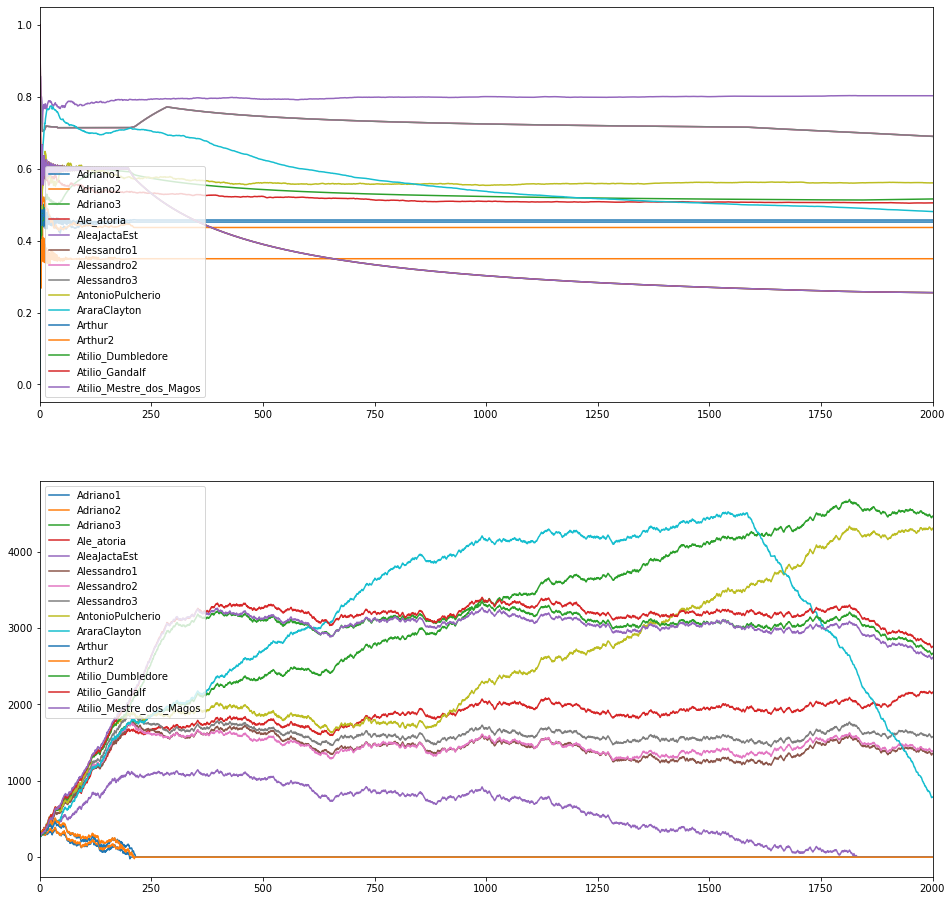

In [54]:
f, ax = plt.subplots(2,1, figsize=(16,16))
reputacao.plot(ax=ax[0])
comida.plot(ax=ax[1])

In [55]:
import seaborn as sns

In [57]:
#sns.scatterplot(data=, x=reputacao, y=comida)